<a href="https://colab.research.google.com/github/tocom242242/pytorch-cifar10-simple-example/blob/main/pytorch_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision.transforms import InterpolationMode
import matplotlib.pyplot as plt
from tqdm import tqdm

BICUBIC = InterpolationMode.BICUBIC

Files already downloaded and verified
Files already downloaded and verified


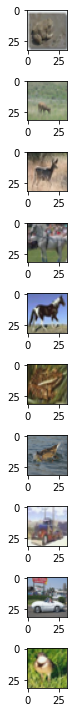

In [17]:
def get_loaders(batch_size):
    ds = torchvision.datasets.CIFAR10
    transform = transforms.Compose([
        transforms.Resize(32, interpolation=BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


    trainset = ds(root='data', train=True, download=True, transform=transform)
    indices = torch.arange(10000) 
    trainset = Subset(trainset, indices)

    n_samples = len(trainset)
    train_size = int(len(trainset) * 0.9)
    val_size = n_samples - train_size
    trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])


    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2,
                                                drop_last=False)
    val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2,
                                                drop_last=False)

    testset = ds(root='data', train=False, download=True, transform=transform)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2,
                                                drop_last=False)
    return train_loader, val_loader, test_loader



def plot_ds(dataset, row=10, col=1, figsize=(20,10)):
    fig_img, ax_img = plt.subplots(row, col, figsize=figsize, tight_layout=True)
    plt.figure()
    for i in range(row):
        img1,_ = dataset[i]
        img1 = denormalization(img1)
        img1 = np.squeeze(img1)
        ax_img[i].imshow(img1)
        
    fig_img.savefig("data_sample.png", dpi=100)
    plt.close()

def inverse_normalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device)
    if mean.ndim == 1:
        mean = mean.view(-1, 1, 1)
    if std.ndim == 1:
        std = std.view(-1, 1, 1)
    tensor.mul_(std).add_(mean)
    return tensor

def denormalization(x):
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
    x = inverse_normalize(x, mean, std)
    x = x.cpu().detach().numpy()
    # x = (x.transpose(1, 2, 0)).astype(np.uint8)
    x = (x.transpose(1, 2, 0) * 255.0).astype(np.uint8)

    return x

train_loader, val_loader, test_loader = get_loaders(batch_size=32)
plot_ds(train_loader.dataset)

In [18]:

class AverageMeter(object):
    def __init__(self, name, fmt=":f"):
        self.name = name
        self.fmt = fmt
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = "{name} {val" + self.fmt + "} ({avg" + self.fmt + "})"
        return fmtstr.format(**self.__dict__)


class ClassifierModel(torch.nn.Module):
    def __init__(self):
        super(ClassifierModel, self).__init__()

        # 畳み込み層
        self.cnn_layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=128,
                      kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(in_channels=128, out_channels=32,
                      kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=16,
                      kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.Flatten()
        )
        # 全結合層
        self.mlp_layers = torch.nn.Sequential(
            torch.nn.Linear(256, 50),
            torch.nn.ReLU(True),
            torch.nn.Linear(50, 10),
            torch.nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        y = self.mlp_layers(x)
        return y



In [19]:
# 学習など
epochs = 100 
model = ClassifierModel()
train_loss = AverageMeter("train_loss")
train_acc = AverageMeter("train_acc")
val_loss = AverageMeter("val_loss")
val_acc = AverageMeter("val_acc")
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=30, gamma=0.1
)

min_loss = np.inf
for epoch in tqdm(range(epochs)):
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs.squeeze(), y)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted==y).sum().item()/y.size(0)
        train_loss.update(loss.data)
        train_acc.update(accuracy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    for x, y in val_loader:
        outputs = model(x)
        loss = criterion(outputs.squeeze(), y)
        val_loss.update(loss.data)

        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted==y).sum().item()/y.size(0)
        val_acc.update(accuracy)

    if val_loss.avg < min_loss:
        torch.save(model.state_dict(), "model.pth")
        min_loss = val_loss.avg

    print(
        "[epoch :{:.1f} train_loss: {} val_loss: {} train_acc: {} val_acc: {}] ".format(
            epoch, train_loss.avg, val_loss.avg,
            train_acc.avg, val_acc.avg
        )
    )
    scheduler.step()
    train_loss.reset()
    val_loss.reset()

model.load_state_dict(torch.load("model.pth"))

  1%|          | 1/100 [00:10<17:49, 10.80s/it]

[epoch :0.0 train_loss: 2.2454187870025635 val_loss: 2.1994056701660156 train_acc: 0.21564716312056736 val_acc: 0.2724609375] 


  2%|▏         | 2/100 [00:21<17:33, 10.75s/it]

[epoch :1.0 train_loss: 2.164048194885254 val_loss: 2.1275994777679443 train_acc: 0.2689494680851064 val_acc: 0.32275390625] 


  3%|▎         | 3/100 [00:32<17:30, 10.83s/it]

[epoch :2.0 train_loss: 2.098240375518799 val_loss: 2.0777924060821533 train_acc: 0.30939716312056736 val_acc: 0.3483072916666667] 


  4%|▍         | 4/100 [00:43<17:15, 10.79s/it]

[epoch :3.0 train_loss: 2.0578508377075195 val_loss: 2.048924207687378 train_acc: 0.3387355939716312 val_acc: 0.371337890625] 


  5%|▌         | 5/100 [00:53<17:01, 10.75s/it]

[epoch :4.0 train_loss: 2.0264081954956055 val_loss: 2.0248618125915527 train_acc: 0.363209219858156 val_acc: 0.3888671875] 


  6%|▌         | 6/100 [01:04<16:53, 10.78s/it]

[epoch :5.0 train_loss: 2.0001955032348633 val_loss: 2.008354425430298 train_acc: 0.38362514775413714 val_acc: 0.4020182291666667] 


  7%|▋         | 7/100 [01:15<16:43, 10.79s/it]

[epoch :6.0 train_loss: 1.9759856462478638 val_loss: 1.9962338209152222 train_acc: 0.40181737588652483 val_acc: 0.41183035714285715] 


  8%|▊         | 8/100 [01:26<16:37, 10.84s/it]

[epoch :7.0 train_loss: 1.956904411315918 val_loss: 1.986407995223999 train_acc: 0.41828734485815605 val_acc: 0.4229736328125] 


  9%|▉         | 9/100 [01:37<16:28, 10.86s/it]

[epoch :8.0 train_loss: 1.936981439590454 val_loss: 1.977776050567627 train_acc: 0.4333382584712372 val_acc: 0.4314236111111111] 


 10%|█         | 10/100 [01:48<16:15, 10.84s/it]

[epoch :9.0 train_loss: 1.920453429222107 val_loss: 1.9686310291290283 train_acc: 0.44731826241134753 val_acc: 0.43876953125] 


 11%|█         | 11/100 [01:58<16:04, 10.84s/it]

[epoch :10.0 train_loss: 1.9032083749771118 val_loss: 1.9672534465789795 train_acc: 0.46036831076724694 val_acc: 0.44389204545454547] 


 12%|█▏        | 12/100 [02:09<15:53, 10.84s/it]

[epoch :11.0 train_loss: 1.8886638879776 val_loss: 1.9631078243255615 train_acc: 0.4724900265957447 val_acc: 0.448486328125] 


 13%|█▎        | 13/100 [02:20<15:41, 10.82s/it]

[epoch :12.0 train_loss: 1.873077630996704 val_loss: 1.9571551084518433 train_acc: 0.4838379705400982 val_acc: 0.45297475961538464] 


 14%|█▍        | 14/100 [02:31<15:30, 10.82s/it]

[epoch :13.0 train_loss: 1.8586674928665161 val_loss: 1.957456111907959 train_acc: 0.49472042806484295 val_acc: 0.45633370535714285] 


 15%|█▌        | 15/100 [02:42<15:21, 10.84s/it]

[epoch :14.0 train_loss: 1.841896414756775 val_loss: 1.9500420093536377 train_acc: 0.5052083333333334 val_acc: 0.460546875] 


 16%|█▌        | 16/100 [02:53<15:09, 10.83s/it]

[epoch :15.0 train_loss: 1.8295190334320068 val_loss: 1.9440724849700928 train_acc: 0.5151540336879432 val_acc: 0.46490478515625] 


 17%|█▋        | 17/100 [03:04<15:00, 10.85s/it]

[epoch :16.0 train_loss: 1.820279836654663 val_loss: 1.9480476379394531 train_acc: 0.5243989883187318 val_acc: 0.46834788602941174] 


 18%|█▊        | 18/100 [03:14<14:45, 10.80s/it]

[epoch :17.0 train_loss: 1.8080034255981445 val_loss: 1.9418281316757202 train_acc: 0.5334109042553191 val_acc: 0.4713541666666667] 


 19%|█▉        | 19/100 [03:25<14:34, 10.80s/it]

[epoch :18.0 train_loss: 1.7952349185943604 val_loss: 1.942569613456726 train_acc: 0.5421157614781635 val_acc: 0.4738898026315789] 


 20%|██        | 20/100 [03:36<14:22, 10.78s/it]

[epoch :19.0 train_loss: 1.7827016115188599 val_loss: 1.941645622253418 train_acc: 0.5505984042553191 val_acc: 0.4763671875] 


 21%|██        | 21/100 [03:46<14:10, 10.77s/it]

[epoch :20.0 train_loss: 1.7744688987731934 val_loss: 1.9394867420196533 train_acc: 0.5587375464370146 val_acc: 0.4783296130952381] 


 22%|██▏       | 22/100 [03:57<13:57, 10.74s/it]

[epoch :21.0 train_loss: 1.7631070613861084 val_loss: 1.9310342073440552 train_acc: 0.5664843246292715 val_acc: 0.48060191761363635] 


 23%|██▎       | 23/100 [04:08<13:48, 10.77s/it]

[epoch :22.0 train_loss: 1.755523443222046 val_loss: 1.9363733530044556 train_acc: 0.5738947348134443 val_acc: 0.48259171195652173] 


 24%|██▍       | 24/100 [04:19<13:35, 10.72s/it]

[epoch :23.0 train_loss: 1.7453837394714355 val_loss: 1.9423108100891113 train_acc: 0.5810708481087471 val_acc: 0.4837239583333333] 


 25%|██▌       | 25/100 [04:29<13:24, 10.72s/it]

[epoch :24.0 train_loss: 1.7378126382827759 val_loss: 1.937553882598877 train_acc: 0.5880629432624114 val_acc: 0.485625] 


 26%|██▌       | 26/100 [04:40<13:15, 10.74s/it]

[epoch :25.0 train_loss: 1.7254565954208374 val_loss: 1.9392366409301758 train_acc: 0.5948112725040916 val_acc: 0.48696664663461536] 


 27%|██▋       | 27/100 [04:51<13:07, 10.78s/it]

[epoch :26.0 train_loss: 1.7224944829940796 val_loss: 1.9444820880889893 train_acc: 0.6012156882059364 val_acc: 0.4877387152777778] 


 28%|██▊       | 28/100 [05:02<12:56, 10.78s/it]

[epoch :27.0 train_loss: 1.713020920753479 val_loss: 1.933026909828186 train_acc: 0.6075505002532928 val_acc: 0.48904854910714285] 


 29%|██▉       | 29/100 [05:12<12:44, 10.76s/it]

[epoch :28.0 train_loss: 1.7058920860290527 val_loss: 1.930372714996338 train_acc: 0.613658596233798 val_acc: 0.4903353987068966] 


 30%|███       | 30/100 [05:23<12:32, 10.76s/it]

[epoch :29.0 train_loss: 1.6977651119232178 val_loss: 1.9440271854400635 train_acc: 0.6196217494089834 val_acc: 0.49098307291666665] 


 31%|███       | 31/100 [05:34<12:21, 10.75s/it]

[epoch :30.0 train_loss: 1.677717924118042 val_loss: 1.9406726360321045 train_acc: 0.6257685598261268 val_acc: 0.49177797379032256] 


 32%|███▏      | 32/100 [05:45<12:09, 10.72s/it]

[epoch :31.0 train_loss: 1.6732081174850464 val_loss: 1.938964605331421 train_acc: 0.6316143062943262 val_acc: 0.492767333984375] 


 33%|███▎      | 33/100 [05:55<11:58, 10.73s/it]

[epoch :32.0 train_loss: 1.669284462928772 val_loss: 1.9286460876464844 train_acc: 0.637256877283473 val_acc: 0.4938742897727273] 


 34%|███▍      | 34/100 [06:06<11:46, 10.71s/it]

[epoch :33.0 train_loss: 1.6684749126434326 val_loss: 1.9391330480575562 train_acc: 0.6425903473091364 val_acc: 0.49462890625] 


 35%|███▌      | 35/100 [06:17<11:40, 10.77s/it]

[epoch :34.0 train_loss: 1.6667617559432983 val_loss: 1.9301131963729858 train_acc: 0.6477235309017224 val_acc: 0.49559151785714284] 


 36%|███▌      | 36/100 [06:28<11:34, 10.85s/it]

[epoch :35.0 train_loss: 1.6659103631973267 val_loss: 1.9320100545883179 train_acc: 0.652556146572104 val_acc: 0.4963650173611111] 


 37%|███▋      | 37/100 [06:39<11:18, 10.77s/it]

[epoch :36.0 train_loss: 1.6649974584579468 val_loss: 1.9385175704956055 train_acc: 0.6571395198389879 val_acc: 0.4970703125] 


 38%|███▊      | 38/100 [06:49<11:03, 10.71s/it]

[epoch :37.0 train_loss: 1.663469910621643 val_loss: 1.9329497814178467 train_acc: 0.6614962439343038 val_acc: 0.49789268092105265] 


 39%|███▉      | 39/100 [07:00<10:49, 10.65s/it]

[epoch :38.0 train_loss: 1.6626803874969482 val_loss: 1.9342292547225952 train_acc: 0.6657204719039825 val_acc: 0.4986728766025641] 


 40%|████      | 40/100 [07:10<10:36, 10.61s/it]

[epoch :39.0 train_loss: 1.6619081497192383 val_loss: 1.9261574745178223 train_acc: 0.669675310283688 val_acc: 0.4994384765625] 


 41%|████      | 41/100 [07:21<10:24, 10.58s/it]

[epoch :40.0 train_loss: 1.66041100025177 val_loss: 1.9295392036437988 train_acc: 0.6735075030271579 val_acc: 0.5001667301829268] 


 42%|████▏     | 42/100 [07:31<10:12, 10.56s/it]

[epoch :41.0 train_loss: 1.6607766151428223 val_loss: 1.9296293258666992 train_acc: 0.6771123564674096 val_acc: 0.5008603050595238] 


 43%|████▎     | 43/100 [07:42<10:00, 10.53s/it]

[epoch :42.0 train_loss: 1.6600748300552368 val_loss: 1.9364596605300903 train_acc: 0.6805624278410028 val_acc: 0.5012945130813954] 


 44%|████▍     | 44/100 [07:52<09:48, 10.51s/it]

[epoch :43.0 train_loss: 1.658457636833191 val_loss: 1.9300142526626587 train_acc: 0.6838984929078015 val_acc: 0.5019753196022727] 


 45%|████▌     | 45/100 [08:03<09:37, 10.49s/it]

[epoch :44.0 train_loss: 1.656218409538269 val_loss: 1.9373732805252075 train_acc: 0.6871306146572104 val_acc: 0.5023871527777778] 


 46%|████▌     | 46/100 [08:13<09:25, 10.47s/it]

[epoch :45.0 train_loss: 1.6563622951507568 val_loss: 1.9343369007110596 train_acc: 0.6902029370952821 val_acc: 0.5028447690217391] 


 47%|████▋     | 47/100 [08:23<09:13, 10.44s/it]

[epoch :46.0 train_loss: 1.6564871072769165 val_loss: 1.9334537982940674 train_acc: 0.6932034668779237 val_acc: 0.5033452460106383] 


 48%|████▊     | 48/100 [08:34<09:01, 10.42s/it]

[epoch :47.0 train_loss: 1.6536635160446167 val_loss: 1.9245625734329224 train_acc: 0.6961043698286052 val_acc: 0.5040486653645834] 


 49%|████▉     | 49/100 [08:44<08:51, 10.43s/it]

[epoch :48.0 train_loss: 1.6526517868041992 val_loss: 1.9406685829162598 train_acc: 0.6989117455492836 val_acc: 0.5042849170918368] 


 50%|█████     | 50/100 [08:54<08:40, 10.40s/it]

[epoch :49.0 train_loss: 1.6525661945343018 val_loss: 1.9309661388397217 train_acc: 0.7015935283687943 val_acc: 0.50474609375] 


 51%|█████     | 51/100 [09:05<08:29, 10.41s/it]

[epoch :50.0 train_loss: 1.6523888111114502 val_loss: 1.9330048561096191 train_acc: 0.7041853532193019 val_acc: 0.5051317401960784] 


 52%|█████▏    | 52/100 [09:15<08:19, 10.41s/it]

[epoch :51.0 train_loss: 1.6498043537139893 val_loss: 1.9347645044326782 train_acc: 0.7067392935079105 val_acc: 0.5055025540865384] 


 53%|█████▎    | 53/100 [09:26<08:09, 10.42s/it]

[epoch :52.0 train_loss: 1.6498761177062988 val_loss: 1.9347658157348633 train_acc: 0.7091759500869798 val_acc: 0.5058409492924528] 


 54%|█████▍    | 54/100 [09:36<07:59, 10.43s/it]

[epoch :53.0 train_loss: 1.650675654411316 val_loss: 1.938584327697754 train_acc: 0.7115203079852902 val_acc: 0.5059678819444444] 


 55%|█████▌    | 55/100 [09:47<07:49, 10.44s/it]

[epoch :54.0 train_loss: 1.6477370262145996 val_loss: 1.933426022529602 train_acc: 0.7137955351386203 val_acc: 0.5062144886363636] 


 56%|█████▌    | 56/100 [09:57<07:39, 10.45s/it]

[epoch :55.0 train_loss: 1.647865653038025 val_loss: 1.9322341680526733 train_acc: 0.7160073138297872 val_acc: 0.5066964285714286] 


 57%|█████▋    | 57/100 [10:08<07:30, 10.49s/it]

[epoch :56.0 train_loss: 1.6474814414978027 val_loss: 1.9340324401855469 train_acc: 0.7181512069180043 val_acc: 0.5069558662280702] 


 58%|█████▊    | 58/100 [10:18<07:18, 10.45s/it]

[epoch :57.0 train_loss: 1.6475564241409302 val_loss: 1.9411150217056274 train_acc: 0.7202001559060895 val_acc: 0.5070884967672413] 


 59%|█████▉    | 59/100 [10:28<07:07, 10.43s/it]

[epoch :58.0 train_loss: 1.6458572149276733 val_loss: 1.9306796789169312 train_acc: 0.7222134571462916 val_acc: 0.5074152542372882] 


 60%|██████    | 60/100 [10:39<06:56, 10.41s/it]

[epoch :59.0 train_loss: 1.645092487335205 val_loss: 1.9332355260849 train_acc: 0.7241910460992907 val_acc: 0.5076497395833334] 


 61%|██████    | 61/100 [10:49<06:46, 10.41s/it]

[epoch :60.0 train_loss: 1.6435002088546753 val_loss: 1.9317117929458618 train_acc: 0.7261165126148122 val_acc: 0.5078765368852459] 


 62%|██████▏   | 62/100 [11:00<06:34, 10.39s/it]

[epoch :61.0 train_loss: 1.6421458721160889 val_loss: 1.9367923736572266 train_acc: 0.7279798673072524 val_acc: 0.5080172631048387] 


 63%|██████▎   | 63/100 [11:10<06:24, 10.38s/it]

[epoch :62.0 train_loss: 1.641501784324646 val_loss: 1.9347703456878662 train_acc: 0.7297893448159406 val_acc: 0.5082465277777778] 


 64%|██████▍   | 64/100 [11:20<06:14, 10.41s/it]

[epoch :63.0 train_loss: 1.6406422853469849 val_loss: 1.928444743156433 train_acc: 0.7315613225842199 val_acc: 0.5086669921875] 


 65%|██████▌   | 65/100 [11:31<06:03, 10.39s/it]

[epoch :64.0 train_loss: 1.6411857604980469 val_loss: 1.93476140499115 train_acc: 0.7332549099836334 val_acc: 0.5088942307692308] 


 66%|██████▌   | 66/100 [11:41<05:53, 10.39s/it]

[epoch :65.0 train_loss: 1.6424283981323242 val_loss: 1.9401113986968994 train_acc: 0.7348921394799054 val_acc: 0.5089370265151515] 


 67%|██████▋   | 67/100 [11:52<05:43, 10.40s/it]

[epoch :66.0 train_loss: 1.6418404579162598 val_loss: 1.9359793663024902 train_acc: 0.7365019979887795 val_acc: 0.5090659981343284] 


 68%|██████▊   | 68/100 [12:02<05:32, 10.38s/it]

[epoch :67.0 train_loss: 1.6419026851654053 val_loss: 1.9312257766723633 train_acc: 0.7380547298706717 val_acc: 0.5093347886029411] 


 69%|██████▉   | 69/100 [12:12<05:20, 10.35s/it]

[epoch :68.0 train_loss: 1.6416264772415161 val_loss: 1.9360601902008057 train_acc: 0.7395656670778086 val_acc: 0.5094542572463768] 


 70%|███████   | 70/100 [12:22<05:09, 10.33s/it]

[epoch :69.0 train_loss: 1.6410439014434814 val_loss: 1.9427918195724487 train_acc: 0.7410445162107396 val_acc: 0.5095563616071429] 


 71%|███████   | 71/100 [12:33<04:59, 10.33s/it]

[epoch :70.0 train_loss: 1.640429139137268 val_loss: 1.9447321891784668 train_acc: 0.7424785860553391 val_acc: 0.5095318001760564] 


 72%|███████▏  | 72/100 [12:43<04:49, 10.33s/it]

[epoch :71.0 train_loss: 1.6419486999511719 val_loss: 1.9365793466567993 train_acc: 0.7438682033096927 val_acc: 0.5096299913194444] 


 73%|███████▎  | 73/100 [12:54<04:39, 10.34s/it]

[epoch :72.0 train_loss: 1.6407887935638428 val_loss: 1.9375475645065308 train_acc: 0.7452197488584474 val_acc: 0.5097254922945206] 


 74%|███████▍  | 74/100 [13:04<04:29, 10.35s/it]

[epoch :73.0 train_loss: 1.640641450881958 val_loss: 1.9313753843307495 train_acc: 0.7465407561817137 val_acc: 0.5099635768581081] 


 75%|███████▌  | 75/100 [13:14<04:18, 10.33s/it]

[epoch :74.0 train_loss: 1.6411385536193848 val_loss: 1.9382719993591309 train_acc: 0.747835401891253 val_acc: 0.5100130208333333] 


 76%|███████▌  | 76/100 [13:25<04:07, 10.33s/it]

[epoch :75.0 train_loss: 1.6405352354049683 val_loss: 1.9314682483673096 train_acc: 0.7491076427771557 val_acc: 0.5102282072368421] 


 77%|███████▋  | 77/100 [13:35<03:57, 10.34s/it]

[epoch :76.0 train_loss: 1.6406028270721436 val_loss: 1.930747628211975 train_acc: 0.7503166160081054 val_acc: 0.5104758522727273] 


 78%|███████▊  | 78/100 [13:45<03:46, 10.31s/it]

[epoch :77.0 train_loss: 1.6409730911254883 val_loss: 1.929787278175354 train_acc: 0.7515144799054374 val_acc: 0.5107046274038461] 


 79%|███████▉  | 79/100 [13:55<03:36, 10.32s/it]

[epoch :78.0 train_loss: 1.64040207862854 val_loss: 1.9312762022018433 train_acc: 0.7526778099470329 val_acc: 0.5109770569620253] 


 80%|████████  | 80/100 [14:06<03:26, 10.32s/it]

[epoch :79.0 train_loss: 1.6414507627487183 val_loss: 1.9338836669921875 train_acc: 0.7537940492021277 val_acc: 0.51107177734375] 


 81%|████████  | 81/100 [14:16<03:15, 10.30s/it]

[epoch :80.0 train_loss: 1.6409600973129272 val_loss: 1.9326750040054321 train_acc: 0.7549100888713773 val_acc: 0.5112244405864198] 


 82%|████████▏ | 82/100 [14:26<03:05, 10.29s/it]

[epoch :81.0 train_loss: 1.6414920091629028 val_loss: 1.9272550344467163 train_acc: 0.7559732312748659 val_acc: 0.5115043826219512] 


 83%|████████▎ | 83/100 [14:37<02:54, 10.29s/it]

[epoch :82.0 train_loss: 1.641998529434204 val_loss: 1.9353976249694824 train_acc: 0.7570067504058788 val_acc: 0.5116010918674698] 


 84%|████████▍ | 84/100 [14:47<02:44, 10.30s/it]

[epoch :83.0 train_loss: 1.6403863430023193 val_loss: 1.9393526315689087 train_acc: 0.7580209388720027 val_acc: 0.5116954985119048] 


 85%|████████▌ | 85/100 [14:57<02:34, 10.29s/it]

[epoch :84.0 train_loss: 1.6392948627471924 val_loss: 1.9348971843719482 train_acc: 0.759043856904464 val_acc: 0.511868106617647] 


 86%|████████▌ | 86/100 [15:08<02:24, 10.34s/it]

[epoch :85.0 train_loss: 1.6398825645446777 val_loss: 1.9376983642578125 train_acc: 0.760033966270823 val_acc: 0.5119572129360465] 


 87%|████████▋ | 87/100 [15:18<02:14, 10.34s/it]

[epoch :86.0 train_loss: 1.6386089324951172 val_loss: 1.9409550428390503 train_acc: 0.7610115044428141 val_acc: 0.512066720545977] 


 88%|████████▊ | 88/100 [15:28<02:03, 10.31s/it]

[epoch :87.0 train_loss: 1.6395436525344849 val_loss: 1.936504602432251 train_acc: 0.7619655665699548 val_acc: 0.5121071555397727] 


 89%|████████▉ | 89/100 [15:39<01:53, 10.32s/it]

[epoch :88.0 train_loss: 1.6394541263580322 val_loss: 1.9293391704559326 train_acc: 0.762904414694398 val_acc: 0.5122783532303371] 


 90%|█████████ | 90/100 [15:49<01:43, 10.33s/it]

[epoch :89.0 train_loss: 1.6397122144699097 val_loss: 1.9344372749328613 train_acc: 0.7638223995271868 val_acc: 0.5123480902777777] 


 91%|█████████ | 91/100 [15:59<01:32, 10.31s/it]

[epoch :90.0 train_loss: 1.6397960186004639 val_loss: 1.938293695449829 train_acc: 0.7646922005299664 val_acc: 0.5123841002747253] 


 92%|█████████▏| 92/100 [16:09<01:22, 10.31s/it]

[epoch :91.0 train_loss: 1.6383562088012695 val_loss: 1.9413363933563232 train_acc: 0.7655551379895159 val_acc: 0.5123980978260869] 


 93%|█████████▎| 93/100 [16:20<01:12, 10.30s/it]

[epoch :92.0 train_loss: 1.6400196552276611 val_loss: 1.930856466293335 train_acc: 0.7664007092198581 val_acc: 0.5125693044354839] 


 94%|█████████▍| 94/100 [16:30<01:01, 10.29s/it]

[epoch :93.0 train_loss: 1.63912034034729 val_loss: 1.9333178997039795 train_acc: 0.767229468462351 val_acc: 0.5126433676861702] 


 95%|█████████▌| 95/100 [16:40<00:51, 10.28s/it]

[epoch :94.0 train_loss: 1.6389117240905762 val_loss: 1.9322350025177002 train_acc: 0.7680396136618141 val_acc: 0.5127775493421053] 


 96%|█████████▌| 96/100 [16:51<00:41, 10.27s/it]

[epoch :95.0 train_loss: 1.6395355463027954 val_loss: 1.938276767730713 train_acc: 0.7688328808362884 val_acc: 0.5128377278645834] 


 97%|█████████▋| 97/100 [17:01<00:30, 10.27s/it]

[epoch :96.0 train_loss: 1.6400316953659058 val_loss: 1.936187744140625 train_acc: 0.7696063646998611 val_acc: 0.5129470038659794] 


 98%|█████████▊| 98/100 [17:11<00:20, 10.28s/it]

[epoch :97.0 train_loss: 1.6381324529647827 val_loss: 1.9461941719055176 train_acc: 0.7703810247503257 val_acc: 0.5128946109693877] 


 99%|█████████▉| 99/100 [17:21<00:10, 10.29s/it]

[epoch :98.0 train_loss: 1.637831211090088 val_loss: 1.9336211681365967 train_acc: 0.7711333190056594 val_acc: 0.51303069760101] 


100%|██████████| 100/100 [17:32<00:00, 10.52s/it]

[epoch :99.0 train_loss: 1.6400741338729858 val_loss: 1.9405659437179565 train_acc: 0.7718461879432624 val_acc: 0.5130859375] 


<All keys matched successfully>

In [20]:
# 評価
model.eval()
accuracy = 0
num_total = 0
for x, y in test_loader:
    outputs = model(x)
    _, predicted = torch.max(outputs.data, 1)
    accuracy += (predicted==y).sum().item()
    num_total += y.size(0)

accracy = accuracy/num_total
print(f"accuracy:{accracy}")

accuracy:0.5383
